# Imports

In [81]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Read data

In [17]:
bike_rentals = pd.read_csv('bike_rental_hour.csv', index_col='instant')
bike_rentals.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Columns

- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rentals
- **season** - The season in which the rentals occurred
- **yr** - The year the rentals occurred
- **mnth** - The month the rentals occurred
- **hr** - The hour the rentals occurred
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (**casual** + **registered**)

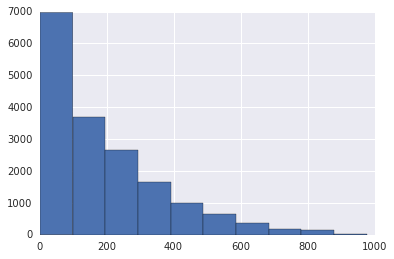

In [18]:
bike_rentals['cnt'].hist()

In [65]:
bike_rentals.corr()['cnt'].abs().sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
time_label    0.378318
hum           0.322911
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

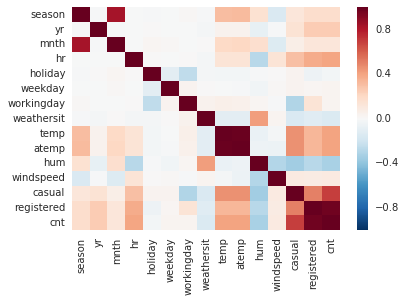

In [20]:
sns.heatmap(bike_rentals.corr())

# Goal

To predict total number of bikes people rent per hour (the cnt column). Compare different ml techniques here.

# Features

## Hours

Change hours to time of day labels

In [22]:
4 in range(1, 4)

False

In [26]:
def assign_label(hour):
    if hour in range(6,12): # Morning
        return 1
    elif hour in range(12,18): # Afternoon
        return 2
    elif hour in range(18,24): # Evening
        return 3
    elif hour in range(0,6): # Night
        return 4

In [27]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

# Split data

Using root mean squared error since it punishes further out values and is applicable to numeric and continuous data

In [30]:
train = bike_rentals.sample(frac=0.8)

In [33]:
merged = bike_rentals.merge(train, how='left', indicator=True)

In [34]:
merged.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label,_merge
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4,both
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4,left_only
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4,left_only
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4,left_only
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4,both


In [35]:
test = merged[merged['_merge'] == 'left_only']

# Model

## Linear regression

These columns leak info or are redundant with others

In [98]:
non_trainable_cols = ['dteday', 'casual', 'registered', 'cnt']

### Feature selection

In [99]:
linear_train = list(train.columns)
for col in non_trainable_cols:
    linear_train.remove(col)

In [100]:
corr = bike_rentals.corr()['cnt'].abs()

In [101]:
non_linear_cols = corr[corr < 0.2].index

In [102]:
non_linear_cols

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'windspeed'],
      dtype='object')

In [103]:
for col in non_linear_cols:
    linear_train.remove(col)

### Train

In [104]:
lr = LinearRegression()
lr.fit(train[linear_train], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [105]:
linear_predict = lr.predict(test[linear_train])

In [107]:
linear_rmse = np.sqrt(mean_squared_error(linear_predict, test['cnt']))
linear_rmse

135.27547116923844

Pretty bad even if I play around with column filters

## Decision tree

### Feature selection

In [111]:
tree_train = list(train.columns)
for col in non_trainable_cols:
    tree_train.remove(col)

In [112]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train[tree_train], train['cnt'])
dtree_pred = tree_reg.predict(test[tree_train])
dtree_rmse = np.sqrt(mean_squared_error(dtree_pred, test['cnt']))
dtree_rmse

56.950738181358204

Now try different min leaves

In [114]:
np.sqrt(1911)

43.71498598878879

In [119]:
for i in range(2,20):
    tree_reg = DecisionTreeRegressor(min_samples_leaf=i)
    tree_reg.fit(train[tree_train], train['cnt'])
    dtree_pred = tree_reg.predict(test[tree_train])
    dtree_rmse = np.sqrt(mean_squared_error(dtree_pred, test['cnt']))
    print("Min samp leaves: {} /t RMSE: {}".format(i, dtree_rmse))
    

Min samp leaves: 2 /t RMSE: 54.567794577982035
Min samp leaves: 3 /t RMSE: 53.14913641628099
Min samp leaves: 4 /t RMSE: 52.0818431289908
Min samp leaves: 5 /t RMSE: 51.47845478502437
Min samp leaves: 6 /t RMSE: 52.60285770703714
Min samp leaves: 7 /t RMSE: 53.192598537243015
Min samp leaves: 8 /t RMSE: 53.533333206530166
Min samp leaves: 9 /t RMSE: 53.05742808800199
Min samp leaves: 10 /t RMSE: 54.22265139021411
Min samp leaves: 11 /t RMSE: 54.598543644013525
Min samp leaves: 12 /t RMSE: 54.69966195987986
Min samp leaves: 13 /t RMSE: 54.942630387361426
Min samp leaves: 14 /t RMSE: 55.20682712322408
Min samp leaves: 15 /t RMSE: 56.03124348897291
Min samp leaves: 16 /t RMSE: 56.75159100188189
Min samp leaves: 17 /t RMSE: 57.036879329027244
Min samp leaves: 18 /t RMSE: 57.73668085340674
Min samp leaves: 19 /t RMSE: 57.34434351769822


Just want to play around with GridSearchCV

In [129]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'min_samples_leaf': [i for i in range(1,20)]
}
tree_reg = DecisionTreeRegressor()
clf = GridSearchCV(tree_reg, parameters, scoring='neg_mean_squared_error',verbose=1)

In [130]:
clf.fit(train[tree_train], train['cnt'])

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    2.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [131]:
clf.best_params_

{'min_samples_leaf': 6}

This is better, but still pretty high

## Random forest

In [133]:
forest_reg = RandomForestRegressor()
forest_reg.fit(train[tree_train], train['cnt'])
forest_pred = forest_reg.predict(test[tree_train])
forest_rmse = np.sqrt(mean_squared_error(forest_pred, test['cnt']))
forest_rmse

45.69061446152961

In [135]:
for i in range(1, 50, 10):
    forest_reg = RandomForestRegressor(min_samples_leaf=i)
    forest_reg.fit(train[tree_train], train['cnt'])
    forest_pred = forest_reg.predict(test[tree_train])
    forest_rmse = np.sqrt(mean_squared_error(forest_pred, test['cnt']))
    print("Min samp leaves: {} /t RMSE: {}".format(i, forest_rmse))

Min samp leaves: 1 /t RMSE: 45.92840761831969
Min samp leaves: 11 /t RMSE: 51.02712343343868
Min samp leaves: 21 /t RMSE: 57.13667438596054
Min samp leaves: 31 /t RMSE: 65.42240459461601
Min samp leaves: 41 /t RMSE: 68.29476692959159


In [137]:
for i in range(1, 11):
    forest_reg = RandomForestRegressor(min_samples_leaf=i)
    forest_reg.fit(train[tree_train], train['cnt'])
    forest_pred = forest_reg.predict(test[tree_train])
    forest_rmse = np.sqrt(mean_squared_error(forest_pred, test['cnt']))
    print("Min samp leaves: {} /t RMSE: {}".format(i, forest_rmse))

Min samp leaves: 1 /t RMSE: 45.58066229957692
Min samp leaves: 2 /t RMSE: 45.00295210720859
Min samp leaves: 3 /t RMSE: 44.210012211510325
Min samp leaves: 4 /t RMSE: 46.03666157975587
Min samp leaves: 5 /t RMSE: 45.695021940204526
Min samp leaves: 6 /t RMSE: 47.272856429752125
Min samp leaves: 7 /t RMSE: 47.978549921198514
Min samp leaves: 8 /t RMSE: 48.57597076048622
Min samp leaves: 9 /t RMSE: 50.03245101352818
Min samp leaves: 10 /t RMSE: 50.98321384136628


As expected, random forest did best